In [31]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import random

import cv2
from skimage import io
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from tqdm import tqdm
import skimage.morphology as morph
from scipy import ndimage as ndi
from scipy.stats import itemfreq
from sklearn.externals import joblib
import pylab
%matplotlib inline 

In [32]:
data_path = 'data/validation_data.npz'
batch_size = 1

In [33]:
def plots(imgs, figsize=(12,6), rows=1, title=None, titles=None):
    f = plt.figure(figsize=figsize)
    if title is not None: plt.title(title)
    for i in range(len(imgs)):
        sp = f.add_subplot(rows, len(imgs)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=8)
        plt.imshow(np.squeeze(imgs[i]), cmap='gray')

In [34]:
def load_data():
#     generator = gen.SegDataGenerator(validation_split=0.2)
#     data = generator.flow_from_directory(data_path, subset='training', batch_size=batch_size,
#                                         class_mode='segmentation', color_mode='grayscale',
#                                         use_contour=True, label_bw=True)
    data = np.load(data_path)
    imgs = data['images']
    masks_gt = data['masks_gt']
    contours_gt = data['contours_gt']
    masks_pred = data['masks_pred']
    contours_pred = data['contours_pred']

    return imgs, masks_gt, contours_gt, masks_pred, contours_pred

In [45]:
def mean_blob_size(mask):
    # decide the size of the structure element
    labels, labels_nr = ndi.label(mask)
    if labels_nr < 2:
        mean_area = 1
        mean_radius = 1
    else:
        mean_area = int(itemfreq(labels)[1:, 1].mean())
        mean_radius = int(np.round(np.sqrt(mean_area / np.pi)))
    return mean_area, mean_radius

In [55]:
def pad_mask(mask, pad):
    if pad <= 1:
        pad = 2
    h = mask.shape[0]
    w = mask.shape[1]
    h_pad = h + 2 * pad
    w_pad = w + 2 * pad
    mask_padded = np.zeros((h_pad, w_pad))
    mask_padded[pad:pad + h, pad:pad + w] = mask
    mask_padded[pad - 1, :] = 1
    mask_padded[pad + h + 1, :] = 1
    mask_padded[:, pad - 1] = 1
    mask_padded[:, pad + w + 1] = 1

    return mask_padded

In [56]:
def crop_mask(mask, crop):
    if crop <= 1:
        crop = 2
    h, w = mask.shape
    mask_cropped = mask[crop:h - crop, crop:w - crop]
    return mask_cropped

In [90]:
def morphological_method(image, mask_gt, contour_gt, mask_pred, contour_pred):
    mask_gt = np.squeeze(mask_gt, axis=2)
    contour_gt = np.squeeze(contour_gt, axis=2)
    mask_pred = np.squeeze(mask_pred, axis=2)
    contour_pred = np.squeeze(contour_pred, axis=2)
    
    # mask -> binary mask, otsu
    m_thresh = threshold_otsu(mask_pred)
    c_thresh = threshold_otsu(contour_pred)
    mask_binary = mask_pred > m_thresh
    contour_binary = contour_pred > c_thresh
    
    # combine mask and contour and fill the holes
    mask_tmp = np.where(mask_binary | contour_binary, 1, 0)
    mask_tmp = ndi.binary_fill_holes(mask_tmp)
    print("binary mask and combined, fill holes")
    plots([mask_binary, contour_binary, mask_tmp])
    
    # close region
    area, radius = mean_blob_size(mask_binary)
    struct_size = int(1.25 * radius)
    struct_el = morph.disk(struct_size)
    mask_padded = pad_mask(mask_tmp, pad=struct_size)
    mask_padded = morph.binary_closing(mask_padded, selem=struct_el)
    mask_tmp = crop_mask(mask_padded, crop=struct_size)
    print("close")
    plots([mask_gt, mask_binary, mask_tmp])
    
    # erase the small artifacts
    area, radius = mean_blob_size(mask_binary)
    struct_size = int(0.75 * radius)
    struct_el = morph.disk(struct_size)
    mask_tmp = np.where(contour_binary & (~mask_binary), 0, mask_tmp)    # remove contour
    mask_padded = pad_mask(mask_tmp, pad=struct_size)
    mask_padded = morph.binary_opening(mask_padded, selem=struct_el)    # remove small artifact
    mask_tmp = crop_mask(mask_padded, crop=struct_size)
    print("open")
    plots([mask_gt, mask_binary, mask_tmp])
    
    # back to begining
    mask_tmp = np.where(mask_binary | mask_tmp, 1, 0)
    mask_tmp = ndi.binary_fill_holes(mask_tmp)
    print("final result")
    plots([mask_gt, mask_binary, mask_tmp])
    
    return mask_tmp

In [111]:
def morphological_method_test(image, mask_gt, contour_gt, mask_pred, contour_pred):
    mask_gt = np.squeeze(mask_gt, axis=2)
    contour_gt = np.squeeze(contour_gt, axis=2)
    mask_pred = np.squeeze(mask_pred, axis=2)
    contour_pred = np.squeeze(contour_pred, axis=2)
    
    # mask -> binary mask, otsu
    m_thresh = threshold_otsu(mask_pred)
    c_thresh = threshold_otsu(contour_pred)
    mask_binary = mask_pred > m_thresh
    contour_binary = contour_pred > c_thresh
    
    contour_binary_thin = morph.binary_erosion(contour_binary)
    
    # cut the mask by contour
    mask_tmp = np.where(~mask_binary | contour_binary_thin, 0, 1)
#     mask_tmp = ndi.binary_fill_holes(mask_tmp)
    print("cut the mask by contour")
    plots([mask_gt, mask_binary, contour_binary, contour_binary_thin, mask_tmp])
    

In [91]:
def visualize(image, mask_gt, contour_gt, mask_pred, contour_pred):
    print("visualize")
    mask_gt = np.squeeze(mask_gt, axis=2)
    contour_gt = np.squeeze(contour_gt, axis=2)
    mask_pred = np.squeeze(mask_pred, axis=2)
    contour_pred = np.squeeze(contour_pred, axis=2)
    print("original masks")
    plots([image, mask_gt, contour_gt])
    plots([image, mask_pred, contour_pred])
    
    # mask -> binary mask, otsu
    m_thresh = threshold_otsu(mask_pred)
    c_thresh = threshold_otsu(contour_pred)
    mask_binary = mask_pred > m_thresh
    contour_binary = contour_pred > c_thresh
    plots([image, mask_binary, contour_binary])
    
#     label_mask, num_cell_mask = ndi.label(mask_binary)   
#     plots([image, label_mask])
    mask_tmp = np.where(mask_binary & ~contour_binary, 1, 0)
#     mask_tmp = np.tile(np.expand_dims(mask_tmp, axis=2), (1,1,3))
    plots([image, mask_binary, mask_tmp])
    
    # get each cell and do mophological
    mask_label, num_cell_mask = ndi.label(mask_binary)
    mask_color = np.zeros((img_height, img_width, 3))
    print(num_cell_mask)
    for i in range(num_cell_mask):
        mask_part = np.where(make_label == i+1, 1, 0)
        mask_part = ndi.binary_fill_holes(mask_part)
        
    
    
    

In [29]:
imgs, masks_gt, contours_gt, masks_pred, contours_pred = load_data()

18
cut the mask by contour


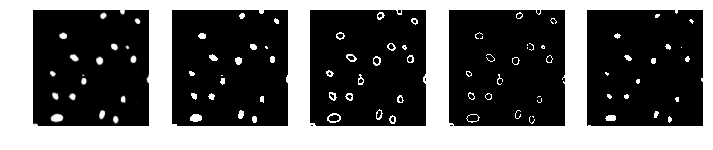

In [118]:
idx = int(imgs.shape[0] * np.random.rand())
print(idx)
img = imgs[idx]
mask_gt = masks_gt[idx]
contour_gt = contours_gt[idx]
mask_pred = masks_pred[idx]
contour_pred = contours_pred[idx]
morphological_method_test(img, mask_gt, contour_gt, mask_pred, contour_pred)
# visualize(img, mask_gt, contour_gt, mask_pred, contour_pred)